In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import copy
from torch.utils.data import DataLoader, Dataset
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import seaborn
from torch.autograd import Variable

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5
import dataset_parameters as params

# DATASET = 'akribian'
DATASET = 'assistments_2009'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
# DATASET = 'ednet'

TIME_STEPS = params.time_steps_dict[DATASET]

IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/sakt/' 
MODEL_PATH = BASE_DIR + 'models/saint/' 

# Training parameters
BATCH_SIZE = 64
LATENT_DIM = 128 # latent dimension
PADDING = 0
SHUFFLE = True
TIME_STEPS = params.time_steps_dict[DATASET]
#EPOCHS = params.epochs_dict[DATASET]
EPOCHS = 100
NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_IDS = params.exercise_id_dict[DATASET]
ROWS_PER_READ = 1000000
HEADS_EN = 4
HEADS_DE = 4
LAYERS_EN = 1
LAYERS_DE = 2
WARMUP = 4000
DROPOUT = 0.1

EARLY_STOPPING_TOLERANCE = 3

# File paths
INPUT_PATH = IN_DATA_PATH + "processed.h5"

In [2]:
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


# Model class

In [3]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff , out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff , out_features=dim_ff)

    def forward(self,ffn_in):
        return  self.layer2(   F.relu( self.layer1(ffn_in) )   )
        

class Encoder_block(nn.Module):
    """
    M = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    O = SkipConct(FFN(LayerNorm(M)))
    """

    def __init__(self , dim_model, heads_en, total_ex ,total_cat, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.embd_ex =   nn.Embedding( total_ex , embedding_dim = dim_model )                   # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model )                  #positional embedding
        #self.embd_pos   = PositionalEncoding(  dim_model, 0., seq_len )                          #positional embedding

        self.multi_en = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_en,  )     # multihead attention    ## todo add dropout, LayerNORM
        self.ffn_en = Feed_Forward_block( dim_model )                                            # feedforward block     ## todo dropout, LayerNorm
        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, in_ex, in_cat, first_block=True):

        ## todo create a positional encoding ( two options numeric, sine)
        if first_block:
            in_ex = self.embd_ex( in_ex )
            in_cat = self.embd_cat( in_cat )
            #combining the embedings
            out = in_ex + in_cat                      # (b,n,d)
        else:
            out = in_ex
        
        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )
        out = out + in_pos                                      # Applying positional embedding

        out = out.permute(1,0,2)                                # (n,b,d)  # print('pre multi', out.shape )
        
        #Multihead attention                            
        n,_,_ = out.shape
        out = self.layer_norm1( out )                           # Layer norm
        skip_out = out
        out, attn_wt = self.multi_en( out , out , out ,
                                attn_mask=get_mask(seq_len=n))  # attention mask upper triangular
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        #feed forward
        out = out.permute(1,0,2)                                # (b,n,d)
        out = self.layer_norm2( out )                           # Layer norm 
        skip_out = out
        out = self.ffn_en( out )
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        return out


class Decoder_block(nn.Module):
    """
    M1 = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    M2 = SkipConct(Multihead(LayerNorm(M1;O;O)))
    L = SkipConct(FFN(LayerNorm(M2)))
    """

    def __init__(self,dim_model ,total_in, heads_de,seq_len, dropout  ):
        super().__init__()
        self.seq_len    = seq_len
        self.embd_in    = nn.Embedding(  total_in , embedding_dim = dim_model )                  #interaction embedding
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model )                  #positional embedding
        #self.embd_pos   = PositionalEncoding(  dim_model, 0., seq_len )
        self.multi_de1  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M1 multihead for interaction embedding as q k v
        self.multi_de2  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M2 multihead for M1 out, encoder out, encoder out as q k v
        self.ffn_en     = Feed_Forward_block( dim_model )                                         # feed forward layer

        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.layer_norm3 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, in_in, en_out,first_block=True):

         ## todo create a positional encoding ( two options numeric, sine)
        if first_block:
            in_in = self.embd_in( in_in )

            #combining the embedings
            out = in_in                         # (b,n,d)
        else:
            out = in_in

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )
        out = out + in_pos                                          # Applying positional embedding

        out = out.permute(1,0,2)                                    # (n,b,d)# print('pre multi', out.shape )
        n,_,_ = out.shape

        #Multihead attention M1                                     ## todo verify if E to passed as q,k,v
        out = self.layer_norm1( out )
        skip_out = out
        out, attn_wt = self.multi_de1( out , out , out, 
                                     attn_mask=get_mask(seq_len=n)) # attention mask upper triangular
        out = skip_out + out                                        # skip connection
        out = self.dropout(out)

        #Multihead attention M2                                     ## todo verify if E to passed as q,k,v
        en_out = en_out.permute(1,0,2)                              # (b,n,d)-->(n,b,d)
        en_out = self.layer_norm2( en_out )
        skip_out = out
        out, attn_wt = self.multi_de2( out , en_out , en_out,
                                    attn_mask=get_mask(seq_len=n))  # attention mask upper triangular
        out = out + skip_out
        out = self.dropout(out)

        #feed forward
        out = out.permute(1,0,2)                                    # (b,n,d)
        out = self.layer_norm3( out )                               # Layer norm 
        skip_out = out
        out = self.ffn_en( out )                                    
        out = out + skip_out                                        # skip connection
        out = self.dropout(out)


        return out

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_mask(seq_len):
    ##todo add this to device
    return torch.from_numpy( np.triu(np.ones((seq_len ,seq_len)), k=1).astype('bool')).cuda()

def get_pos(seq_len):
    # use sine positional embeddinds
    return torch.arange( seq_len ).unsqueeze(0)
    #return torch.arange( seq_len ).unsqueeze(1)

class saint(nn.Module):
    def __init__(self,dim_model,num_en, num_de ,heads_en, total_ex ,total_cat, total_in, heads_de, seq_len, dropout ):
        super().__init__( )

        self.num_en = num_en
        self.num_de = num_de

        self.encoder = get_clones(Encoder_block(dim_model, heads_en, total_ex, total_cat, seq_len, dropout), num_en)
        self.decoder = get_clones(Decoder_block(dim_model ,total_in, heads_de, seq_len, dropout)           , num_de)

        self.out = nn.Linear(in_features= dim_model , out_features=1)
    
    def forward(self,in_ex, in_cat,  in_in ):
        
        padding_mask = in_ex == 0 # (batch, sequence). pytorch wants it in this format for some reason
        padding_mask = padding_mask.cuda()

        ## pass through each of the encoder blocks in sequence
        first_block = True
        for x in range(self.num_en):
            if x>=1:
                first_block = False
            in_ex = self.encoder[x]( in_ex, in_cat ,first_block=first_block)
            in_cat = in_ex                                  # passing same output as q,k,v to next encoder block

        
        ## pass through each decoder blocks in sequence
        first_block = True
        for x in range(self.num_de):
            if x>=1:
                first_block = False
            in_in = self.decoder[x]( in_in , en_out= in_ex, first_block=first_block )

        ## Output layer
        in_in = torch.sigmoid( self.out( in_in ) )
        return in_in

# Model training

In [5]:
#model = gundam( ex_total= NUMBER_OF_EXERCISES, seq_len= TIME_STEPS, dim= LATENT_DIM, heads= 8, dout= 0.2 ).cuda()
model = saint(dim_model=LATENT_DIM,
            seq_len=TIME_STEPS,
            num_en=LAYERS_EN,
            num_de=LAYERS_DE,
            heads_en=HEADS_EN,
            heads_de=HEADS_DE,
            total_ex= NUMBER_OF_IDS,
            total_cat= NUMBER_OF_EXERCISES,
            total_in= 3,
            dropout = DROPOUT ).cuda()

criterion = nn.BCELoss()
#optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8))
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
## Training the model
print_freq = 10
graph_freq = 10

losses_history = []

val_aucs = []

previous_auc = 0.0

no_improvement_streak = 0
best_auc = 0.0

h5_file = h5py.File(INPUT_PATH,'r')

# labels_val = torch.from_numpy(h5_file['labels_val'][:]).flatten()

number_of_train_windows = h5_file['exercises_train'].shape[0]
number_of_val_windows = h5_file['exercises_val'].shape[0]

for epoch in range(EPOCHS):
  print("Epoch %i" % (epoch+1))
  total_loss_print = 0.0
  total_loss_graph = 0.0

  for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

    exercises_train = h5_file['exercises_train'][read_index:read_index+ROWS_PER_READ]
    exercise_ids_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
    labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]

    random_indices = np.arange(len(exercises_train))
    np.random.shuffle(random_indices)

    exercises_train = exercises_train[random_indices]
    exercise_ids_train = exercise_ids_train[random_indices]
    labels_train = labels_train[random_indices]

    # found_exercises = len(list(set(exercises_train.flatten())))
    # print("found %i out of max %i exercises" % (found_exercises, NUMBER_OF_EXERCISES))
    # print("there are %i correctness levels" % len(list(set(labels_train.flatten()))))
    # print(list(set(exercises_train.flatten())))

    for idx in range(0, len(exercises_train), BATCH_SIZE):
      # Retrieve data
      cat_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples = torch.from_numpy(exercise_ids_train[idx:idx + BATCH_SIZE]).long().cuda()
      label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).long().cuda()

      shifted_label = torch.roll(label, 1)
      shifted_label[:,0] = 2
      label = torch.unsqueeze(label, 2)

      # Reset optimizer
      optimizer.zero_grad()

      # Predict
      out = model(id_samples, cat_samples, shifted_label)

      # print("output:")
      # print(out.shape)
      # print(out)

      # Calculate loss 
      loss = criterion(out, label.float())
      total_loss_print += loss.item()
      total_loss_graph += loss.item()

      # Optimize
      loss.backward()
      optimizer.step()

      idx_discrete = int(idx / BATCH_SIZE)

      # Print status
      if (idx_discrete % print_freq == print_freq - 1):
        avg_loss = total_loss_print/print_freq
        sys.stdout.write("\rIteration %i/%i, avg loss %f" % (idx+1, number_of_train_windows, avg_loss))
        sys.stdout.flush()
        total_loss_print = 0.0

      # Append to graph
      if (idx_discrete % graph_freq == graph_freq - 1):
        avg_loss = total_loss_graph/graph_freq
        losses_history.append(avg_loss)
        total_loss_graph = 0.0
          
  # Validation step
  # Set evaluation mode
  outs_preds = np.array([])
  val_labels_last = np.array([])
  model.eval()
  # Turn off grad calculation
  with torch.no_grad():
    # Iterate through val data
    for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
      exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
      exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
      labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
      for idx in range(0, len(exercises_val), BATCH_SIZE):
        cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
        id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
        label = labels_val[idx:idx + BATCH_SIZE]
        shifted_label_val = torch.roll(torch.from_numpy(label), 1).long().cuda()
        shifted_label_val[:,0] = 2

        padding_mask = exercises_val[idx:idx + BATCH_SIZE] != 0

        outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val)        
        outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
        outs_pred_indexed = outs_pred_np[padding_mask]
        outs_preds = np.append(outs_preds, outs_pred_indexed)
        label_indexed = label[padding_mask]
        val_labels_last = np.append(val_labels_last, label_indexed)

  # Revert to training mode
  model.train()

  # labels_val = h5_file['labels_val'][:].flatten()
  fpr, tpr, thresholds = roc_curve(val_labels_last, outs_preds)
  auc_score = auc(fpr, tpr)
  #auc_score = roc_auc_score(val_labels_last, outs_preds)
  val_aucs.append(auc_score)
  print("\nValidation AUC: %f" % auc_score)
  auc_diff = auc_score - previous_auc
  if epoch != 0:
    print("AUC difference: %f" % auc_diff)

  if auc_score < best_auc:
    no_improvement_streak += 1
  else:
    no_improvement_streak = 0
    best_auc = auc_score
    torch.save(model.state_dict(), MODEL_PATH + DATASET + ".torch")
    print("Model saved")

  if no_improvement_streak >= EARLY_STOPPING_TOLERANCE:
    break

  previous_auc = auc_score

h5_file.close()

Epoch 1
Iteration 66497/66940, avg loss 0.431659
Validation AUC: 0.688643
Model saved
Epoch 2
Iteration 39617/66940, avg loss 0.358295

KeyboardInterrupt: 

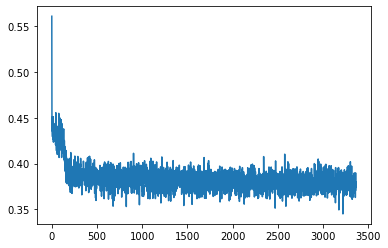

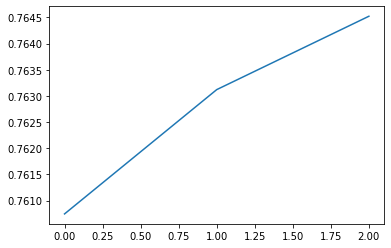

In [6]:
plt.figure(1)
plt.plot(losses_history)

plt.figure(2)
plt.plot(val_aucs)

In [7]:
# Load the best 
model.load_state_dict(torch.load(MODEL_PATH + DATASET + ".torch"))
model.eval()

outs_preds = np.array([])
test_labels_last = np.array([])

BATCH_SIZE = 16

# predict iteratively in batches to avoid overloading VRAM
with h5py.File(INPUT_PATH,'r') as h5_file:
  number_of_test_windows = h5_file['exercises_test'].shape[0]
  for read_index in range(0, number_of_test_windows, ROWS_PER_READ):
    exercises_test = h5_file['exercises_test'][read_index:read_index+ROWS_PER_READ]    
    exercise_ids_test = h5_file['exercise_ids_test'][read_index:read_index+ROWS_PER_READ]
    labels_test = h5_file['labels_test'][read_index:read_index+ROWS_PER_READ]
    for idx in range(0, len(exercises_test), BATCH_SIZE):
      cat_samples_test = torch.from_numpy(exercises_test[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples_test = torch.from_numpy(exercise_ids_test[idx:idx + BATCH_SIZE]).long().cuda()
      label = labels_test[idx:idx + BATCH_SIZE]
      shifted_label_test = torch.roll(torch.from_numpy(label), 1).long().cuda()
      shifted_label_test[:,0] = 2

      padding_mask = exercises_test[idx:idx + BATCH_SIZE] != 0

      # print(ex_samples_test.shape)
      # print(shifted_label_test.shape)
      outs_pred = model(id_samples_test, cat_samples_test, shifted_label_test)        
      outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
      outs_pred_indexed = outs_pred_np[padding_mask]
      outs_preds = np.append(outs_preds, outs_pred_indexed)
      label_indexed = label[padding_mask]
      test_labels_last = np.append(test_labels_last, label_indexed)


print(outs_preds.shape)
print(test_labels_last.shape)

(8321964,)
(8321964,)


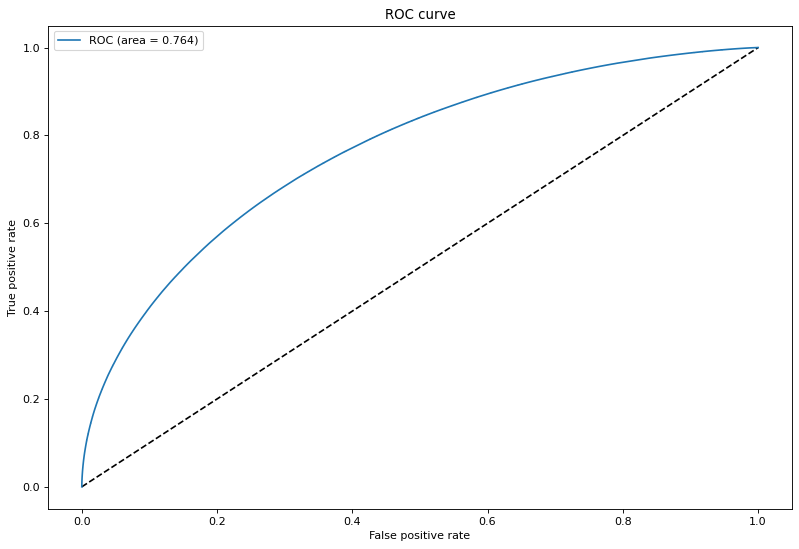

In [8]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_last, outs_preds)
auc_score = auc(fpr_keras, tpr_keras)
# This one reports too high auc...
#auc_score = roc_auc_score(test_labels_last, outs_preds)

plt.figure(3, figsize=(12,8), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [9]:
idx = 100
with h5py.File(INPUT_PATH,'r') as h5_file:
  exercises_test = torch.from_numpy(h5_file['exercises_test'][idx:idx+1]).long().cuda()
  exercise_ids_test = torch.from_numpy(h5_file['exercise_ids_test'][idx:idx+1]).long().cuda()
  labels_test = h5_file['labels_test'][idx:idx+1]
  shifted_label_test = torch.roll(torch.from_numpy(labels_test), 1).long().cuda()
  shifted_label_test[:,0] = 2

  outs_pred = model(exercise_ids_test, exercises_test, shifted_label_test)        

  img_width = TIME_STEPS
  max_width = 30

  ground_truth = labels_test.squeeze().cpu().detach().numpy()
  pred = outs_pred.squeeze().cpu().detach().numpy()


  # Define image
  img = np.ndarray((3, img_width))
  img = img[:, :max_width]

  # Set category color
  ex_color = ex_test.squeeze().cpu().detach().numpy()
  color_dict = dict(enumerate(list(set(ex_color))))
  color_dict = {v:k for k,v in color_dict.items()}
  colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
  colors = colors[-max_width:]
  img[0,:] = colors

  # Set ground truth color
  ground_truth = ground_truth[-max_width:]
  img[1,:] = ground_truth

  # Set prediction color
  pred = pred[-max_width:]
  img[2,:] = pred

  # Show the figure
  plt.figure(4, figsize=(12,8), dpi=100)
  plt.imshow(img)
  plt.text(max_width, 0.15, "Category")
  plt.text(max_width, 1.15, "Ground truth")
  plt.text(max_width, 2.15, "Prediction")

  # Index
  print("index index: %i" % idx)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
with h5py.File(INPUT_PATH,'r') as hf:
  print(hf['labels_val'].shape)